# Instantaneous Frequency Estimation

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

from scipy import signal
import librosa.display
import IPython.display as ipd
from IPython.display import Image, Audio

path_img = '../img/9.musically_informed_audio_decomposition/'
path_data = '../data_FMP/'

from utils.plot_tools import *

- 많은 음악 처리 작업에서 첫 번째 단계는 STFT를 사용하여 오디오 신호를 시간-주파수 표현으로 변환하는 것이다.
- 다음에서는 **순간(instantaneous) 주파수 추정**이라는 기술을 소개한다.
- STFT의 위상(phase) 정보를 보고 도출된 추정치는 STFT에 의해 도입된 주파수 양자화(quantization)를 개선할 수 있다.

- 이제 일부 표기법을 수정하여 이산 STFT의 일부 속성을 보자.
- $x$는 $F_\mathrm{s}$ Hertz의 비율로 샘플링된 주어진 음악 신호를 나타낸다.
- 또한, $\mathcal{X}$를 길이 $N\in\mathbb{N}$ 및 홉 크기 $H\in\mathbb{N}$의 적절한 윈도우 함수를 사용하는 STFT라고 하자.
- 푸리에 계수 $\mathcal{X}(n,k)$의 경우 프레임 인덱스 $n\in\mathbb{Z}$는 물리적 시간 $T_\mathrm{coef}(n) := \frac{n\cdot H}{F_\mathrm{s}}$ (초 단위)와 관련되어 있다. 주파수 지수 $k\in[0:N/2]$는 주파수 $F_\mathrm{coef}(k) := \frac{k\cdot F_\mathrm{s}}{N} $(Hertz로 표시)에 해당한다.

- 특히 이산 STFT는 $F_\mathrm{s}/N$Hz의 분해능(resolution)으로 주파수 축의 선형 샘플링을 할 수 있다. 이 분해능은 특정 시간-주파수 패턴(예: 비브라토 또는 글리산도로 인해 지속적으로 변화하는 패턴)을 정확하게 캡처하는 데 충분하지 않을 수 있다.
- 또한, 주파수의 로그 인식으로 인해, 주파수 축의 선형 샘플링은 스펙트럼의 저주파(low-frequency) 부분에서 특히 문제가 된다.
- 단순히 윈도우 길이 $N$를 증가시켜 주파수 분해능을 높이는 것은 실행 가능한 솔루션이 아니다. 이 프로세스는 시간적(temporal) 분해능을 감소시키기 때문이다.
- 다음에서는 복소수 STFT로 인코딩된 위상 정보를 이용하여 향상된 주파수 추정을 얻는 기법에 대해 논의한다.

## 순간 주파수 (Instantaneous Frequency)

- 우선 주파수 표현 및 측정의 주요 아이디어를 상기해보자. 다음 형식의 복소수 **지수 함수**를 고려한다.
    - $\mathbf{exp}_{\omega,\varphi}:\mathbb{R}\to\mathbb{C}, \quad \mathbf{exp}_\omega(t):= \mathrm{exp}\big (2\pi i(\omega t - \varphi)\big)$
    - 주파수 매개변수 $\omega\in\mathbb{R}$($\mathrm{Hz}$로 측정) 및 위상 매개변수 $\varphi$($360^\circ$의 각도에 해당하는 $1$로 정규화된 라디안으로 측정).
- $\varphi=0$인 경우,
     - $\mathbf{exp}_{\omega} := \mathbf{exp}_{\omega,0}.$


- 시간 매개변수 $t$를 균일하게 증가시키면, 지수 함수는 단위 원(unit circle) 주위의 **원 운동**(**circular motion**)을 설명한다. 실제 및 가상 축에 투영하면 두 개의 **정현파 운동**(**sinusoidal motions**)(코사인 및 사인 함수로 설명됨)이 생성된다.
- 원형 운동을 균일하게 회전하는 바퀴로 생각하면 주파수 매개변수 $\omega$는 단위 시간당 회전 수(이 경우 1초 지속 시간)에 해당한다. 즉, 주파수는 회전율로 해석할 수 있다.
- 이 해석을 기반으로 임의의 시간 간격 $[t_1,t_2]$ 및 $t_1<t_2$ 동안 회전하는 바퀴와 주파수 값을 연결할 수 있다. 이를 위해 시간 $t_1$에서의 각도 위치 $\varphi_1$와 시간 $t_2$에서의 각도 위치 $\varphi_2$를 측정한다. 이는 다음 그림에 설명되어 있다.

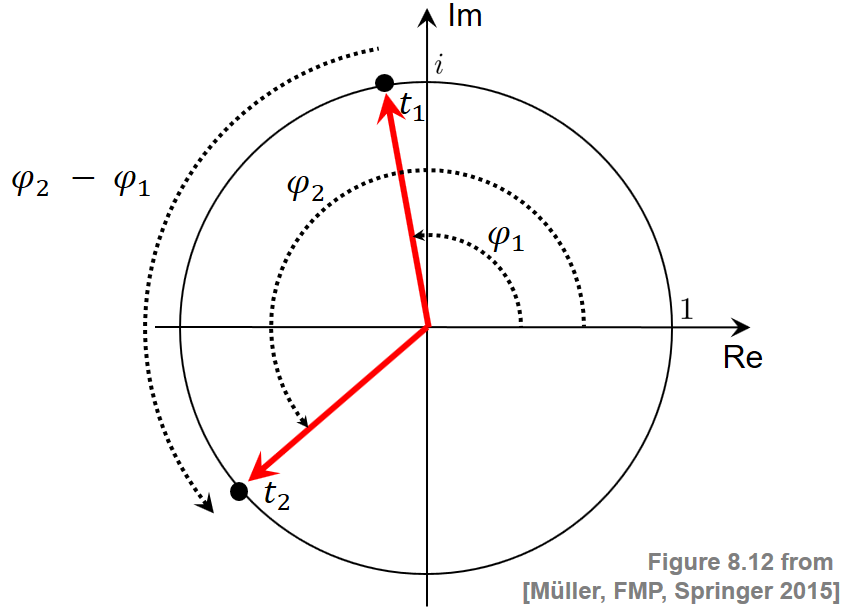

In [3]:
Image(path_img+"FMP_C8_F12.png", width="300px")

- 주파수는 시간 간격의 길이 $t_2-t_1$로 나눈 각도 위치의 변화 $\varphi_2-\varphi_1$로 정의된다.
- 극한의 경우, 시간 간격이 임의로 작아지면 다음과 같이 주어진 **순간 주파수** $\omega_{t_1}$를 얻는다.
     - $ \omega_{t_1}:=\lim_{t_2\to t_1}\frac{\varphi_2-\varphi_1}{t_2-t_1}.$

## Phase Prediction Error

For the moment, let us assume a time-continuous perspective, fixing a frequency value $\omega\in\mathbb{R}$ and two time instances, say $t_1\in\mathbb{R}$ and $t_2\in\mathbb{R}$. Later, we will choose specific values that are related to the STFT parameters. Correlating the signal $x$ with a windowed version of the analysis function $\mathbf{exp}_\omega$, one positioned at $t_1$ and one at $t_2$, we obtain two complex Fourier coefficients. Let $\varphi_1$ and $\varphi_2$ be the phases of these two coefficients, respectively. In the case that the signal $x$ contains a strong frequency component of frequency $\omega$, the two phases $\varphi_1$ and $\varphi_2$ should be consistent in the following way: A rotation of frequency $\omega$ that assumes the angular position $\varphi_1$ at time position $t_1$ should have the phase

\begin{equation}
        \varphi^\mathrm{Pred}:=\varphi_1 + \omega\cdot \Delta t
\end{equation}

at time $t_2$, where $\Delta t:=t_2-t_1$. Therefore, in the case that the signal $x$ behaves similarly to the function $\mathbf{exp}_\omega$, one should have $\varphi_2\approx\varphi^\mathrm{Pred}$. In the case that the signal $x$ oscillates slightly slower than $\mathbf{exp}_\omega$, the phase increment from time instance $t_1$ to instance $t_2$ for the signal $x$ is less than the one for the prototype oscillation $\mathbf{exp}_\omega$. As a result, the phase $\varphi_2$ measured at $t_2$ is less than the predicted phase $\varphi^\mathrm{Pred}$. In the third case that $x$ oscillates slightly faster than $\mathbf{exp}_\omega$, the phase $\varphi_2$ is larger than the predicted phase $\varphi^\mathrm{Pred}$. The three cases are illustrated by the following figure:

<img src="../data/C8/FMP_C8_F13.png" width="400px" align="middle" alt="FMP_C8_F13">

To measure the difference between $\varphi_2$ and $\varphi^\mathrm{Pred}$, we introduce the **prediction error** defined by

\begin{equation}
        \varphi^\mathrm{Err}:=\Psi(\varphi_2-\varphi^\mathrm{Pred}).   
\end{equation}

In this definition, $\Psi:\mathbb{R}\to\left[-0.5,0.5\right]$ is the [**principal argument function**](../C6/C6S1_NoveltyPhase.html), which maps phase differences into the range $[-0.5,0.5]$ by adding or subtracting a suitable integer value, thus avoiding discontinuities when computing phase differences. The prediction error can be used to correct the frequency value $\omega$ to obtain a refined frequency estimate $\mathrm{IF}(\omega)$ for the signal $x$:

\begin{equation}
\label{eq:AudioDeco:Mel:IFE:freqEstCor}
   \mathrm{IF}(\omega) :=  \omega + \frac{\varphi^\mathrm{Err}}{\Delta t}.
\end{equation}

This value (being a bit sloppy in word use) is also called the **instantaneous frequency** (IF), which can be thought of an adjustment of the initial frequency $\omega$. Strictly speaking, rather than referring to a single time instance, the instantaneous frequency refers&mdash;in this case&mdash;to an entire time interval $[t_1,t_2]$. In practice, however, this interval is typically chosen to be very small (on the order of a couple of milliseconds).